# Chapter 8 – Dimensionality Reduction

This notebook contains all the code samples and solutions to the exercises in chapter 8 of *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition* (O'Reilly). *Note: all code examples are based on the author's original GitHub repository.*

**Assignment Instructions:**
Per the assignment guidelines, this notebook reproduces the code from Chapter 8. It also includes theoretical explanations and summaries for each concept, as required.

## Chapter Summary

This chapter explores **Dimensionality Reduction**, the process of reducing the number of features (dimensions) in a dataset. This is often a crucial step for several reasons:

* **Fighting the Curse of Dimensionality:** Many ML problems involve thousands or even millions of features. This high dimensionality makes training slow and can make it harder to find a good solution, as the data becomes very sparse.
* **Speeding up Training:** Fewer features mean faster training.
* **Data Visualization (DataViz):** Reducing dimensions down to 2 or 3 allows us to plot the data and gain insights by visually detecting patterns like clusters.
* **Compression:** It saves space by storing the dataset in a compressed form.

We will explore two main approaches:
1.  **Projection:** This approach projects the data onto a lower-dimensional subspace. The most popular projection technique is **Principal Component Analysis (PCA)**.
2.  **Manifold Learning:** This approach relies on the *manifold assumption*—that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold (a shape bent or twisted in a higher-dimensional space). We'll look at techniques like **Kernel PCA** and **Locally Linear Embedding (LLE)**.

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 3.7 or later is required for the latest versions of Scikit-Learn), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## The Curse of Dimensionality

### Theoretical Explanation

We are used to living in three dimensions, but our intuition fails in high-dimensional space. Many things behave very differently there.

* **Data is Sparse:** In high dimensions, most training instances are likely to be far away from each other. The average distance between two random points in a 1,000,000-dimensional unit hypercube is about 408!
* **Overfitting Risk:** This sparsity means a new instance will likely be far from any training instance, making predictions less reliable and increasing the risk of overfitting.
* **Exponential Data Requirement:** The number of training instances required to reach a given density of data grows *exponentially* with the number of dimensions. With just 100 features, you would need more instances than atoms in the observable universe to maintain the same data density you'd have with one feature.

## Main Approaches for Dimensionality Reduction

### Theoretical Explanation: Projection

In most real-world problems, all training instances don't just spread out uniformly. Instead, they lie within (or close to) a much lower-dimensional **subspace**.

For example, a 3D dataset might lie close to a 2D plane. By **projecting** every instance onto this plane, we can reduce the dataset's dimensionality from 3D to 2D. The challenge is to choose the right hyperplane to project onto, one that preserves as much information (or variance) as possible.

### Theoretical Explanation: Manifold Learning

Projection isn't always the best approach. If the data forms a twisted shape, like the "Swiss roll" dataset, simply projecting it onto a plane would squash the layers together.

This is where **Manifold Learning** comes in. It relies on the **manifold assumption**: that most real-world high-dimensional datasets lie close to a much lower-dimensional **manifold** (a $d$-dimensional shape that can be bent or twisted in $n$-dimensional space, where $d < n$).

Manifold Learning algorithms, like LLE, work by modeling the manifold on which the instances lie. The assumption is that the task (like classification) will be simpler if expressed in the lower-dimensional space of the manifold.

## PCA (Principal Component Analysis)

### Theoretical Explanation

PCA is the most popular dimensionality reduction algorithm. It identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

**1. Preserving the Variance**
To choose the right hyperplane, PCA selects the axis that preserves the maximum amount of variance. This axis is the one that minimizes the mean squared distance between the original data and its projection onto that axis.

**2. Principal Components (PCs)**
PCA finds the axis that accounts for the largest amount of variance in the training set. This is called the **first principal component (PC)**.

It then finds a second axis, orthogonal to the first, that accounts for the largest amount of *remaining* variance. This is the **second PC**. This continues until it finds as many axes as the number of dimensions in the dataset.

The unit vector pointing in the direction of the $i$-th PC is found using a standard matrix factorization technique called **Singular Value Decomposition (SVD)**. SVD decomposes the training set matrix $\mathbf{X}$ into $\mathbf{U} \cdot \mathbf{\Sigma} \cdot \mathbf{V}^\top$. The matrix $\mathbf{V}$ contains all the principal components.


In [2]:
# Code to find the PCs manually using SVD

# Generate a sample 3D dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

# PCA assumes the dataset is centered around the origin
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

# The PCs are the columns of V, which is Vt.T
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

print("First PC:", c1)
print("Second PC:", c2)

First PC: [0.93636116 0.29854881 0.18465208]
Second PC: [-0.34027485  0.90119108  0.2684542 ]


### Theoretical Explanation: Projecting Down to $d$ Dimensions

Once you have the first $d$ principal components, you can reduce the dataset's dimensionality down to $d$ dimensions by projecting it onto the hyperplane defined by them.

To project the training set, you compute the matrix multiplication of the training set $\mathbf{X}$ by the matrix $\mathbf{W}_d$, which is the matrix containing the first $d$ principal components.

$$\mathbf{X}_{d\text{-proj}} = \mathbf{X} \cdot \mathbf{W}_d$$

In [3]:
# Project the training set onto the plane defined by the first two PCs
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

### Code Reproduction: Using Scikit-Learn

Scikit-Learn's `PCA` class makes this much simpler. It automatically takes care of centering the data.

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D_sk = pca.fit_transform(X)

# The components_ attribute holds the transpose of W_d
print("Scikit-Learn PCs:\n", pca.components_.T)

Scikit-Learn PCs:
 [[ 0.93636116 -0.34027485]
 [ 0.29854881  0.90119108]
 [ 0.18465208  0.2684542 ]]


### Theoretical Explanation: Explained Variance Ratio

A useful piece of information is the **explained variance ratio** of each principal component, which indicates the proportion of the dataset's variance that lies along each PC.

This allows you to choose the right number of dimensions. Instead of arbitrarily choosing $d=2$, you can choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%).

A better way is to set `n_components` to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve.

In [5]:
# Find the number of components that preserve 95% of the variance
pca = PCA()
pca.fit(X) # Using the original 3D data from before
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("d for 95% variance:", d)

Explained variance ratio: [0.84248607 0.14631839 0.01119554]
d for 95% variance: 2


In [6]:
# A better way: set n_components=0.95
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
print("Shape of reduced data:", X_reduced.shape)

Shape of reduced data: (60, 2)


### Theoretical Explanation: PCA for Compression & Reconstruction

After dimensionality reduction, the dataset takes up much less space. This is a form of compression.

It is also possible to decompress the reduced dataset back to the original number of dimensions by applying the **inverse transformation**. This won't give you back the original data (since some information was lost), but it will be close.

The mean squared distance between the original data and the reconstructed data is called the **reconstruction error**.

Original shape: (60000, 784)
Reduced shape: (60000, 154)


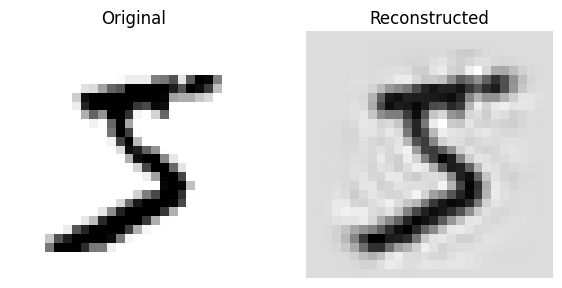

In [7]:
# Using MNIST dataset for a better example
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X_train = mnist["data"][:60000]
y_train = mnist["target"][:60000]

X_test = mnist["data"][60000:]
y_test = mnist["target"][60000:]

# Perform PCA preserving 95% of the variance
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

print("Original shape:", X_train.shape)
print("Reduced shape:", X_reduced.shape)

# Reconstruct the data
X_recovered = pca.inverse_transform(X_reduced)

# Plot an original vs. reconstructed digit
plt.figure(figsize=(7, 4))
plt.subplot(121)
plt.imshow(X_train[0].reshape(28, 28), cmap="binary", interpolation="nearest")
plt.title("Original")
plt.axis("off")
plt.subplot(122)
plt.imshow(X_recovered[0].reshape(28, 28), cmap="binary", interpolation="nearest")
plt.title("Reconstructed")
plt.axis("off")
plt.show()

### Theoretical Explanation: Randomized PCA & Incremental PCA

* **Randomized PCA:** A stochastic algorithm that quickly finds an approximation of the first $d$ principal components. It is much faster than full SVD when $d$ is much smaller than $n$. Scikit-Learn uses this automatically when appropriate if `svd_solver="auto"`.

* **Incremental PCA (IPCA):** This algorithm is useful for large datasets that don't fit in memory. It splits the training set into mini-batches and feeds them one at a time. This is also useful for applying PCA online (as new instances arrive).

In [8]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced_inc = inc_pca.transform(X_train)

## Kernel PCA (kPCA)

### Theoretical Explanation

The **kernel trick** we saw in Chapter 5 (SVMs) can be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. This is called **Kernel PCA (kPCA)**.

It is often good at preserving clusters of instances after projection or unrolling datasets that lie close to a twisted manifold.

How it works:
1.  A kernel function (like the Gaussian RBF kernel) implicitly maps the dataset to a very high-dimensional space (the *feature space*).
2.  It then performs linear PCA in this feature space.
3.  The resulting projection back to a low-dimensional space (e.g., 2D) corresponds to a nonlinear projection in the original space.

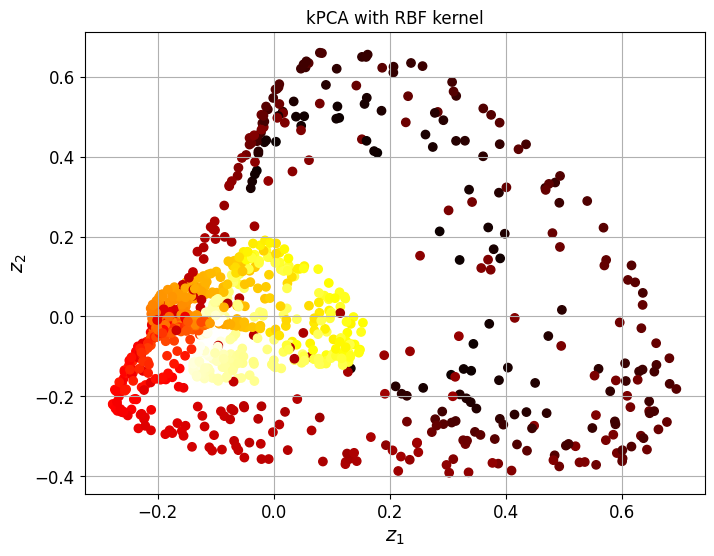

In [9]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA

X_swiss, y_swiss = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced_kpca = rbf_pca.fit_transform(X_swiss)

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced_kpca[:, 0], X_reduced_kpca[:, 1], c=y_swiss, cmap=plt.cm.hot)
plt.title("kPCA with RBF kernel")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.grid(True)
plt.show()

### Theoretical Explanation: Selecting a Kernel and Tuning Hyperparameters

Since kPCA is an unsupervised learning algorithm, there is no obvious metric to help select the best kernel and hyperparameters.

However, dimensionality reduction is often a preparation step for a supervised task (like classification). You can use **grid search** to select the kernel and hyperparameters that lead to the best performance on that task.

Another approach is to select the kernel and hyperparameters that yield the lowest **reconstruction error**. With kPCA, this reconstruction (from the projected space back to the original space) is not as simple as with linear PCA, as it involves finding a *pre-image* in the original space. Scikit-Learn can do this if you set `fit_inverse_transform=True`.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pandas as pd # Import pandas for qcut

# Discretize y_swiss into 3 categories for classification
y_swiss_cat = pd.qcut(y_swiss, q=3, labels=[0, 1, 2])

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs", max_iter=1000)) # Increased max_iter for convergence
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_swiss, y_swiss_cat)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'kpca__gamma': np.float64(0.03), 'kpca__kernel': 'sigmoid'}


In [ ]:
# kPCA for reconstruction
rbf_pca_recon = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                          fit_inverse_transform=True)
X_reduced = rbf_pca_recon.fit_transform(X_swiss)
X_preimage = rbf_pca_recon.inverse_transform(X_reduced)

from sklearn.metrics import mean_squared_error
print("Reconstruction error:", mean_squared_error(X_swiss, X_preimage))

## LLE (Locally Linear Embedding)

### Theoretical Explanation

**Locally Linear Embedding (LLE)** is another powerful *Manifold Learning* technique that does not rely on projections.

How it works:
1.  For each training instance $\mathbf{x}^{(i)}$, the algorithm identifies its $k$ closest neighbors (c.n.).
2.  It then tries to reconstruct $\mathbf{x}^{(i)}$ as a linear function of these neighbors. It finds the weights $\mathbf{W}$ that minimize the squared distance between $\mathbf{x}^{(i)}$ and $\sum_{j} w_{i,j}\mathbf{x}^{(j)}$.
3.  Finally, it maps the training instances to a $d$-dimensional space (where $d < n$) while *preserving* these local linear relationships as much as possible.

This makes it particularly good at unrolling twisted manifolds, like the Swiss roll.

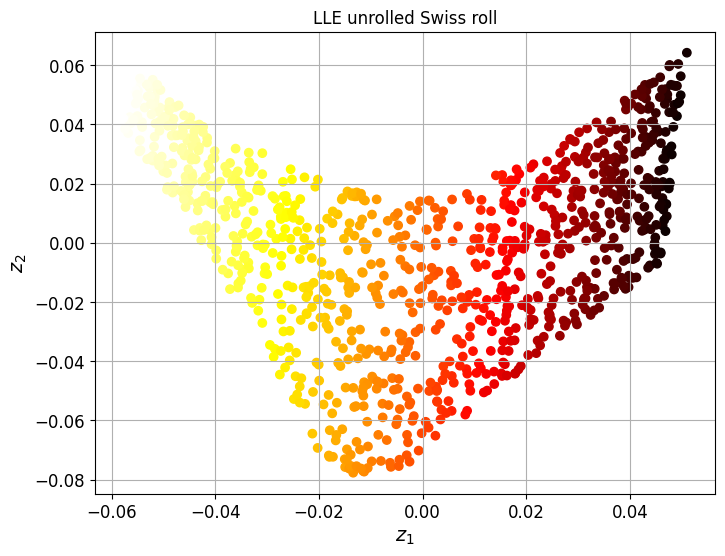

In [12]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X_swiss)

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced_lle[:, 0], X_reduced_lle[:, 1], c=y_swiss, cmap=plt.cm.hot)
plt.title("LLE unrolled Swiss roll")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.grid(True)
plt.show()

## Other Dimensionality Reduction Techniques

### Theoretical Explanation

Scikit-Learn offers several other dimensionality reduction techniques:

* **Multidimensional Scaling (MDS):** Reduces dimensionality while trying to preserve the distances between the instances.
* **Isomap:** Creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the *geodesic distances* (number of nodes on the shortest path) between instances.
* **t-Distributed Stochastic Neighbor Embedding (t-SNE):** Reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization.
* **Linear Discriminant Analysis (LDA):** This is actually a classification algorithm, but during training it learns the most discriminative axes between the classes. These axes can then be used to project the data, keeping classes as far apart as possible.

## Exercises

From Chapter 8, page 233:

1.  What are the main motivations for reducing a dataset’s dimensionality? What are the main drawbacks?
2.  What is the curse of dimensionality?
3.  Once a dataset’s dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?
4.  Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?
5.  Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?
6.  In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA, or Kernel PCA?
7.  How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?
8.  Does it make any sense to chain two different dimensionality reduction algorithms?
9.  Load the MNIST dataset and split it. Train a Random Forest classifier. Then, use PCA to reduce the dataset’s dimensionality (with 95% variance preserved). Train a new Random Forest on the reduced dataset. How long did it take? How does it compare to the previous classifier?
10. Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result.